In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("../data/master_f1_dataset_2025.csv")
df.head()

,Driver,fp2_avg_lap,fp2_best_lap,fp2_total_laps,FastestQualiLap,QualiPosition,RacePosition,DNF,grand_prix
0,ALB,92.966765,77.302,17,75.737,6,5,False,Australia
1,ALO,91.150048,77.330,21,76.288,12,21,True,Australia
2,ANT,85.246222,77.634,18,76.525,16,4,False,Australia
3,BOR,86.275188,77.847,16,76.516,15,21,True,Australia
4,DOO,91.787609,77.394,23,76.315,13,21,True,Australia


In [4]:
df["is_podium_finish"] = df["RacePosition"] <= 3
print(df["is_podium_finish"].value_counts())

is_podium_finish
False    198
True      36
Name: count, dtype: int64


In [5]:
X = df.drop(columns=["RacePosition", "DNF", "grand_prix", "is_podium_finish", "Driver"])
y = df["is_podium_finish"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

print(X.columns)
print(X.dtypes)

Index(['fp2_avg_lap', 'fp2_best_lap', 'fp2_total_laps', 'FastestQualiLap',
       'QualiPosition'],
      dtype='object')
fp2_avg_lap        float64
fp2_best_lap       float64
fp2_total_laps       int64
FastestQualiLap    float64
QualiPosition        int64
dtype: object


RandomForestClassifier:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95        40
        True       1.00      0.43      0.60         7

    accuracy                           0.91        47
   macro avg       0.95      0.71      0.78        47
weighted avg       0.92      0.91      0.90        47



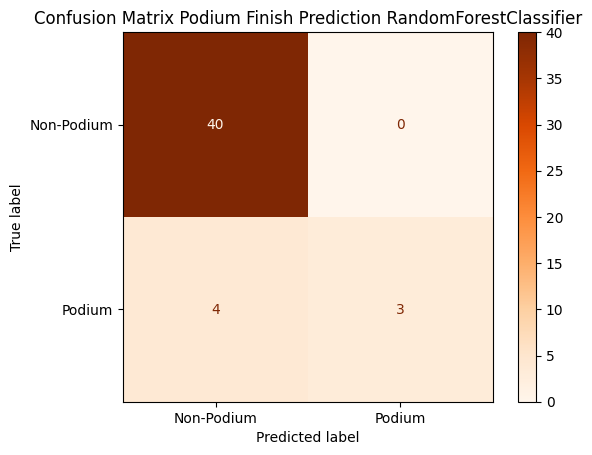

In [34]:
RFC_model = RandomForestClassifier(class_weight='balanced', random_state=22)
RFC_model.fit(X_train,y_train)
y_pred_rfc = RFC_model.predict(X_test)

print("RandomForestClassifier:")
print(classification_report(y_test, y_pred_rfc))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rfc,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Oranges',
    xticks_rotation=0
)
plt.title("Confusion Matrix Podium Finish Prediction RandomForestClassifier")
plt.grid(False)
plt.show()

Gradient Boosting:
              precision    recall  f1-score   support

       False       0.91      1.00      0.95        40
        True       1.00      0.43      0.60         7

    accuracy                           0.91        47
   macro avg       0.95      0.71      0.78        47
weighted avg       0.92      0.91      0.90        47



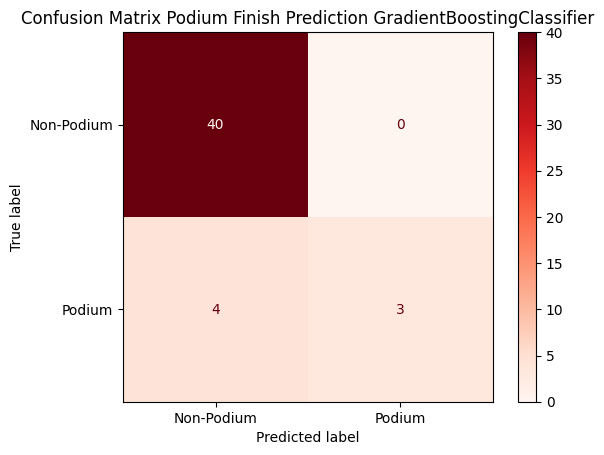

In [35]:
gb_model = GradientBoostingClassifier(random_state=22)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_gb,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Reds',
    xticks_rotation=0
)

plt.title("Confusion Matrix Podium Finish Prediction GradientBoostingClassifier")
plt.grid(False)
plt.show()

Logistic Regression (With QualiPosition, Scaled):
              precision    recall  f1-score   support

       False       1.00      0.85      0.92        40
        True       0.54      1.00      0.70         7

    accuracy                           0.87        47
   macro avg       0.77      0.93      0.81        47
weighted avg       0.93      0.87      0.89        47



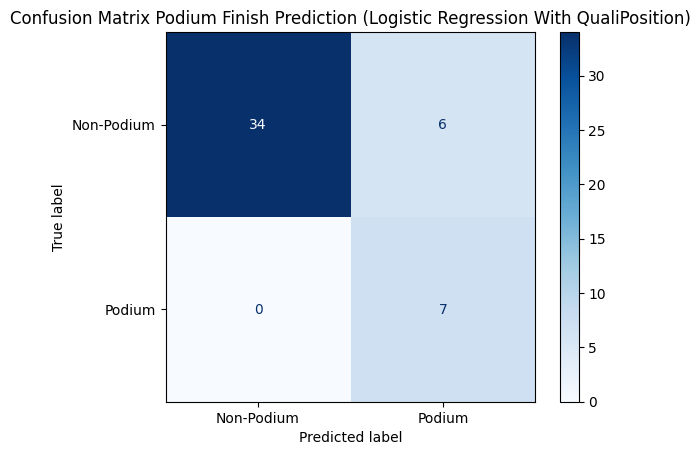

In [36]:
# scaled logistic regression
# the model that i am going to save, as it gives the best outcomes 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(class_weight='balanced', random_state=22)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression (With QualiPosition, Scaled):")
print(classification_report(y_test, y_pred_log))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_log,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Blues',
    xticks_rotation=0
)

plt.title("Confusion Matrix Podium Finish Prediction (Logistic Regression With QualiPosition)")
plt.grid(False)
plt.show()

Logistic Regression (Without QualiPosition, Scaled):
              precision    recall  f1-score   support

       False       0.92      0.55      0.69        40
        True       0.22      0.71      0.33         7

    accuracy                           0.57        47
   macro avg       0.57      0.63      0.51        47
weighted avg       0.81      0.57      0.63        47



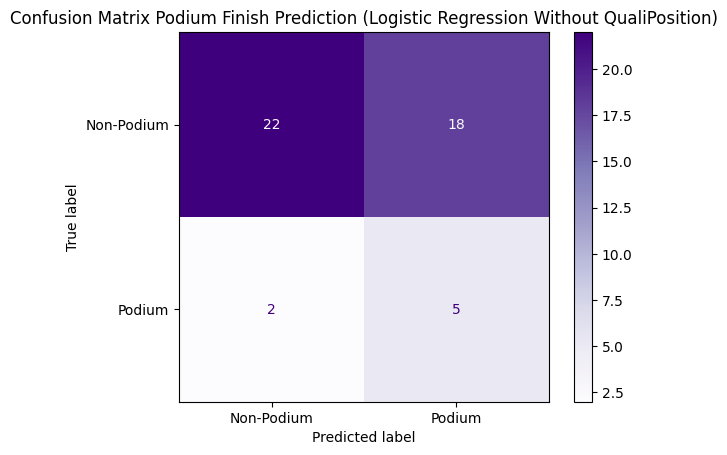

In [37]:
# scaled logistic regression with no quali position data
# redefined train/test split 
X_dropped = X.drop(columns=["QualiPosition"])
X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped = train_test_split(X_dropped, y, stratify=y, random_state=22, test_size=0.2)

# rescale the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

# apply logistic regression
log_model_dropped = LogisticRegression(class_weight='balanced', random_state=22)
log_model_dropped.fit(X_train_scaled, y_train_dropped)
y_pred_dropped = log_model_dropped.predict(X_test_scaled)

print("Logistic Regression (Without QualiPosition, Scaled):")
print(classification_report(y_test_dropped, y_pred_dropped))

ConfusionMatrixDisplay.from_predictions(
    y_test_dropped, y_pred_dropped,
    display_labels=['Non-Podium', 'Podium'],
    cmap='Purples',
    xticks_rotation=0
)
plt.title("Confusion Matrix Podium Finish Prediction (Logistic Regression Without QualiPosition)")
plt.grid(False)
plt.show()

In [22]:
print(dict(zip(X.columns, log_model.coef_[0])))

{'fp2_avg_lap': np.float64(0.419389374181113), 'fp2_best_lap': np.float64(0.1876303183757388), 'fp2_total_laps': np.float64(0.22770278761200083), 'FastestQualiLap': np.float64(-0.6173121880994755)}


In [13]:
import joblib
joblib.dump(log_model, '../models/podium_predictor_logistic_regression.pkl')

['../models/podium_predictor_logistic_regression.pkl']